# Coding a simple decision tree with high quantile and 80/20 ratio
***

This notebook was developed from an initial template given by **Code Canteen** and data scientist Lila Rose. They can be reach at http://futurecoders.org.uk/. The initial work was based on using medians as indicators and a train/test ratio of 80/20.<br>

In the following notebooks, we will use different ratios and different indicators, to see how the decision trees change (or not). For the complete explanations, please refer to the notebook *Decision-Tree-coded-model-Median-80-20*.

Author of the final document: Ester Giménez Mojón.

In this worksheet we are going to code a decision tree, which will use the calculated probabilities to make decisions about wheter a row of given data would be classified as `Iris virginica`, `Iris setosa` or `Iris versicolor`, or not, based on sepal and petal dimensions. With this information, species would be further predicted by probabilities of error.

This notebook will provide a decision tree for every one of the three different types of Iris considered. Each tree will be independent of each other.

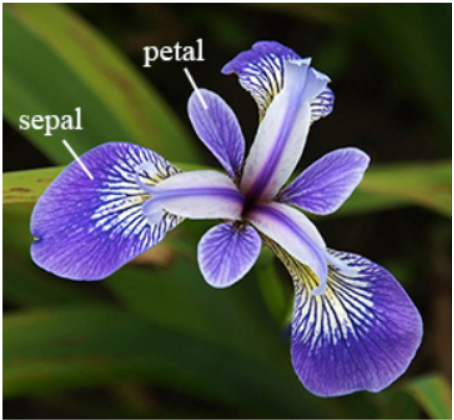

We will use:<br>

- quantile (0.75) as an indicator.<br>
- train/test percentages as 80/20.

### 1. READ THE IRIS DATASET
***

Like with the previous notebook, we will use the same iris dataset, located at https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv into a dataframe called iris_data.<br>

The columns in the CSV file do not have headings, so we need to add them:<br>

> url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv"<br>
> names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'species']<br>
> iris_data = pd.read_csv(url, name=names)<br>

There are 150 rows of data, no empty spaces.<br>

In [1]:
import pandas as pd
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv"
names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'species']
iris_data = pd.read_csv(url, names=names)
iris_data.describe()

,sepal-length,sepal-width,petal-length,petal-width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [2]:
iris_data.quantile(0.75)

sepal-length    6.4
sepal-width     3.3
petal-length    5.1
petal-width     1.8
Name: 0.75, dtype: float64

In [3]:
iris_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal-length  150 non-null    float64
 1   sepal-width   150 non-null    float64
 2   petal-length  150 non-null    float64
 3   petal-width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


### 2. SPLIT THE DATA INTO TRAIN AND TEST DATASETS
***

In this case, I will use 80% train, 20% test as the split and the upper quantile as indicator.

In [4]:
# import the train_test_split function
from sklearn.model_selection import train_test_split

# create the classification variables from all columns
train, test = train_test_split(iris_data, test_size=0.20, random_state=2)
# random_state fixes the results of the calculation every time that the whole notebook is run, otherwise it will show
# different results, due to the random test_size, as it will choose different items every time.
train.describe()

,sepal-length,sepal-width,petal-length,petal-width
count,120.000000,120.000000,120.000000,120.000000
mean,5.897500,3.055833,3.862500,1.243333
std,0.813382,0.443401,1.741344,0.753115
min,4.300000,2.000000,1.000000,0.100000
25%,5.200000,2.800000,1.600000,0.400000
50%,5.800000,3.000000,4.450000,1.400000
75%,6.400000,3.325000,5.100000,1.825000
max,7.900000,4.400000,6.900000,2.500000


The splitting will be used later, to see if the remaining data (the test set) relates very well with the train set.<br>

In order to manage decision trees, we need to decide which item we will use as a discriminator for separating values above and below it. We can use the median, the mean, quartiles (25 or 75), etc. In this case, I will use the means.<br>

### 3. ASSUMPTIONS
***

Same as in the previous notebook, we will only use the data we have on the 3 species as a representation of the species.

In [30]:
sl_indicator = iris_data['sepal-length'].quantile(0.75)
sw_indicator = iris_data['sepal-width'].quantile(0.75)
pl_indicator = iris_data['petal-length'].quantile(0.75)
pw_indicator = iris_data['petal-width'].quantile(0.75)

print(sl_indicator, sw_indicator, pl_indicator, pw_indicator)
display(train.describe())

6.4 3.3 5.1 1.8


,sepal-length,sepal-width,petal-length,petal-width
count,120.000000,120.000000,120.000000,120.000000
mean,5.897500,3.055833,3.862500,1.243333
std,0.813382,0.443401,1.741344,0.753115
min,4.300000,2.000000,1.000000,0.100000
25%,5.200000,2.800000,1.600000,0.400000
50%,5.800000,3.000000,4.450000,1.400000
75%,6.400000,3.325000,5.100000,1.825000
max,7.900000,4.400000,6.900000,2.500000


The upper quantiles change slightly because it is not the same to calculate the averages of the whole set than the means of the train set. <br>

- upper quantiles of the whole set: 6.4, 3.325, 5.1, 1.825<br>
- upper quantiles after split: 6.4, 3.3, 5.1, 1.8<br>

### 4. PROPORTION OF VALUES ON or ABOVE AND BELOW THE INDICATOR
***

This calculates the probability of elements in a specified column, that are:<br>

- **above** the median in relation to the total number of elements in that column. <br>
- **below** the median in relation to the total number of elements of the column.<br>

This will be used to calculate the Gini Index of the above and the below values.

__SEPAL LENGHT__

In [31]:
# Calculate the proportion of values in sepal-length column that are on or above the upper quantiles
sl_vi_above_indicator = train[train['sepal-length'] >= sl_indicator]['sepal-length'].count() / train['sepal-length'].count()
sl_vi_below_indicator = train[train['sepal-length'] < sl_indicator]['sepal-length'].count() / train['sepal-length'].count()
print(sl_vi_above_indicator)
print(sl_vi_below_indicator)

0.275
0.725


__SEPAL WIDTH__

In [32]:
# Calculate the proportion of values in sepal-width column that are on or above the upper quantiles

sw_indicator_vi_above = train[train['sepal-width'] >= sw_indicator]['sepal-width'].count() / train['sepal-width'].count()
sw_indicator_vi_below = train[train['sepal-width'] < sw_indicator]['sepal-width'].count() / train['sepal-width'].count()
print(sw_indicator_vi_above)
print(sw_indicator_vi_below)

0.2916666666666667
0.7083333333333334


__PETAL LENGHT__

In [33]:
# Calculate the proportion of values in petal-length column that are on or above the upper quantiles
pl_vi_above_indicator = train[train['petal-length'] >= pl_indicator]['petal-length'].count() / train['petal-length'].count()
pl_vi_below_indicator = train[train['petal-length'] < pl_indicator]['petal-length'].count() / train['petal-length'].count()
print(pl_vi_above_indicator)
print(pl_vi_below_indicator)

0.3
0.7


__PETAL WIDTH__

In [34]:
# Calculate the proportion of values in petal-width column that are on or above the upper quantiles
pw_vi_above_indicator = train[train['petal-width'] >= pw_indicator]['petal-width'].count() / train['petal-width'].count()
pw_vi_below_indicator = train[train['petal-width'] < pw_indicator]['petal-width'].count() / train['petal-width'].count()
print(pw_vi_above_indicator)
print(pw_vi_below_indicator)

0.325
0.675


The results are as follow:

|Upper Quantiles|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH| 
|---------------|------------|-----------|------------|-----------| 
|xx_vi_above_indicator|0.275|0.292|0.3|0.325|
|xx_vi_below_indicator|0.725|0.708|0.7|0.675|

### 5 - CALCULATION OF THE PROPORTION OF VALUES (CONDITIONED PROBABILITY) ON OR ABOVE THE INDICATOR THAT ARE OF A GIVEN SPECIES 

We will calculate the probability of a row being on or above the indicator and of a given species at the same time. <br>
The same will be done with the rows being under the indicator and of a given species at the same time.<br>
The calculations will be done for every column as well.<br>

The steps would be, for example:<br>

- Filter by values in the sepal-length column that are on or above the upper quantile (sl_indicator) and the species column being Iris-virginica.<br>
- Filter by values in the sepal-length column that are on or above the upper quantile (sl_indicator) only.<br>
- Divide both results.<br>

Instead of filtering the columns again and repeating the steps above to know which numbers are ON or ABOVE the indicator and NOT of one of the given species, we will do a substraction:<br>

> = 1 - (the proportion of those that are Iris virginica)<br>

### 5.1 - On or above the indicator and `Iris virginica` 

In [35]:
# calculate the proportion of results where the value is on or above the upper quintiles that are of the species Iris-virginica
sl_vi_above = train[(train['sepal-length'] >= sl_indicator) & (train['species'] == 'Iris-virginica')]['sepal-length'].count() / train[train['sepal-length'] >= sl_indicator]['sepal-length'].count()
sw_vi_above = train[(train['sepal-width'] >= sw_indicator) & (train['species'] == 'Iris-virginica')]['sepal-width'].count() / train[train['sepal-width'] >= sw_indicator]['sepal-width'].count()
pl_vi_above = train[(train['petal-length'] >= pl_indicator) & (train['species'] == 'Iris-virginica')]['petal-length'].count() / train[train['petal-length'] >= pl_indicator]['petal-length'].count()
pw_vi_above = train[(train['petal-width'] >= pw_indicator) & (train['species'] == 'Iris-virginica')]['petal-width'].count() / train[train['petal-width'] >= pw_indicator]['petal-width'].count()

print(sl_vi_above, sw_vi_above, pl_vi_above, pw_vi_above)

0.7575757575757576 0.2 0.9722222222222222 0.9743589743589743


In [36]:
# calculate the proportion of results where the column is above the upper quintiles that are NOT of the species Iris-virginica

no_sl_vi_above = 1 - sl_vi_above
no_sw_vi_above = 1 - sw_vi_above
no_pl_vi_above = 1 - pl_vi_above
no_pw_vi_above = 1 - pw_vi_above

print(no_sl_vi_above, no_sw_vi_above, no_pl_vi_above, no_pw_vi_above)

0.24242424242424243 0.8 0.02777777777777779 0.02564102564102566


The results for `Iris Virginica` are as follow:

|Conditioned Probab|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH| 
|------------------|------------|-----------|------------|-----------| 
|above Iris virg.|0.7576|0.2|0.9722|0.9744|
|above not Iris virg.|0.2424|0.8|0.0277|0.0256|

### 5.2 - On or above the indicator and `Iris setosa`

In [37]:
# calculate the proportion of results where the value is on or above the upper quintiles that are of the species Iris-setosa
sl_vi_above_cet = train[(train['sepal-length'] >= sl_indicator) & (train['species'] == 'Iris-setosa')]['sepal-length'].count() / train[train['sepal-length'] >= sl_indicator]['sepal-length'].count()
sw_vi_above_cet = train[(train['sepal-width'] >= sw_indicator) & (train['species'] == 'Iris-setosa')]['sepal-width'].count() / train[train['sepal-width'] >= sw_indicator]['sepal-width'].count()
pl_vi_above_cet = train[(train['petal-length'] >= pl_indicator) & (train['species'] == 'Iris-setosa')]['petal-length'].count() / train[train['petal-length'] >= pl_indicator]['petal-length'].count()
pw_vi_above_cet = train[(train['petal-width'] >= pw_indicator) & (train['species'] == 'Iris-setosa')]['petal-width'].count() / train[train['petal-width'] >= pw_indicator]['petal-width'].count()

print(sl_vi_above_cet, sw_vi_above_cet, pl_vi_above_cet, pw_vi_above_cet)

0.0 0.7714285714285715 0.0 0.0


In [38]:
# calculate the proportion of results where the column is above the upper quintiles that are NOT of the species Iris-setosa

no_sl_vi_above_cet = 1 - sl_vi_above_cet
no_sw_vi_above_cet = 1 - sw_vi_above_cet
no_pl_vi_above_cet = 1 - pl_vi_above_cet
no_pw_vi_above_cet = 1 - pw_vi_above_cet

print(no_sl_vi_above_cet, no_sw_vi_above_cet, no_pl_vi_above_cet, no_pw_vi_above_cet)

1.0 0.22857142857142854 1.0 1.0


The results for `Iris setosa` are as follow:

|Conditioned Probab|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH| 
|------------------|------------|-----------|------------|-----------| 
|above Iris s.|0.0|0.7714|0.0|0.0|
|above not Iris s.|1.0|0.2286|1.0|1.0|

### 5.3 - On or above the indicator and `Iris versicolor`

In [39]:
# calculate the proportion of results where the value is on or above the upper quintiles that are of the species Iris-versicolor
sl_vi_above_ver = train[(train['sepal-length'] >= sl_indicator) & (train['species'] == 'Iris-versicolor')]['sepal-length'].count() / train[train['sepal-length'] >= sl_indicator]['sepal-length'].count()
sw_vi_above_ver = train[(train['sepal-width'] >= sw_indicator) & (train['species'] == 'Iris-versicolor')]['sepal-width'].count() / train[train['sepal-width'] >= sw_indicator]['sepal-width'].count()
pl_vi_above_ver = train[(train['petal-length'] >= pl_indicator) & (train['species'] == 'Iris-versicolor')]['petal-length'].count() / train[train['petal-length'] >= pl_indicator]['petal-length'].count()
pw_vi_above_ver = train[(train['petal-width'] >= pw_indicator) & (train['species'] == 'Iris-versicolor')]['petal-width'].count() / train[train['petal-width'] >= pw_indicator]['petal-width'].count()

print(sl_vi_above_ver, sw_vi_above_ver, pl_vi_above_ver, pw_vi_above_ver)

0.24242424242424243 0.02857142857142857 0.027777777777777776 0.02564102564102564


In [40]:
# calculate the proportion of results where the column is above the upper quintiles that are NOT of the species Iris-versicolor

no_sl_vi_above_ver = 1 - sl_vi_above_ver
no_sw_vi_above_ver = 1 - sw_vi_above_ver
no_pl_vi_above_ver = 1 - pl_vi_above_ver
no_pw_vi_above_ver= 1 - pw_vi_above_ver

print(no_sl_vi_above_ver, no_sw_vi_above_ver, no_pl_vi_above_ver, no_pw_vi_above_ver)

0.7575757575757576 0.9714285714285714 0.9722222222222222 0.9743589743589743


The results for `Iris versicolor` are as follow:

|Conditioned Probab|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH| 
|------------------|------------|-----------|------------|-----------| 
|above Iris ver.|0.2424|0.0286|0.02777|0.0256|
|above not Iris ver.|0.7575|0.9714|0.9722|0.9743|

### 6 - CALCULATION OF THE PROPORTION OF VALUES (CONDITIONED PROBABILITY) BELOW THE INDICATOR THAT ARE OF A GIVEN SPECIES

Same as section 5 but below the indicator.

### 6.1 - Below mean and `Iris virginica`

In [41]:
# calculate the proportion of results where the value is below the upper quintiles that are of the species Iris-virginica

sl_vi_below = train[(train['sepal-length'] < sl_indicator) & (train['species'] == 'Iris-virginica')]['sepal-length'].count() / train[train['sepal-length'] < sl_indicator]['sepal-length'].count()
sw_vi_below = (train[(train['sepal-width'] < sw_indicator) & (train['species'] == 'Iris-virginica')]['sepal-width'].count()) / (train[train['sepal-width'] < sw_indicator]['sepal-width'].count())
pl_vi_below = (train[(train['petal-length'] < pl_indicator) & (train['species'] == 'Iris-virginica')]['petal-length'].count()) / (train[train['petal-length'] < pl_indicator]['petal-length'].count())
pw_vi_below = (train[(train['petal-width'] < pw_indicator) & (train['species'] == 'Iris-virginica')]['petal-width'].count()) / (train[train['petal-width'] < pw_indicator]['petal-width'].count())

print(sl_vi_below, sw_vi_below, pl_vi_below, pw_vi_below)

0.19540229885057472 0.4117647058823529 0.08333333333333333 0.04938271604938271


In [42]:
# calculate the proportion of results where the column is below the upper quintiles that are NOT of the species Iris-virginica

no_sl_vi_below = 1-sl_vi_below
no_sw_vi_below = 1-sw_vi_below
no_pl_vi_below = 1-pl_vi_below
no_pw_vi_below = 1-pw_vi_below

print(no_sl_vi_below, no_sw_vi_below, no_pl_vi_below, no_pw_vi_below)

0.8045977011494253 0.5882352941176471 0.9166666666666666 0.9506172839506173


The results for `Iris Virginica` are as follow:

|Conditioned Probab|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH| 
|------------------|------------|-----------|------------|-----------| 
|below Iris virg.|0.1954|0.4117|0.0833|0.0494|
|below not Iris virg.|0.8046|0.5882|0.9166|0.9506|

### 6.2 - Below mean and `Iris setosa`

In [43]:
# calculate the proportion of results where the value is below the upper quintiles that are of the species Iris-setosa

sl_vi_below_set = train[(train['sepal-length'] < sl_indicator) & (train['species'] == 'Iris-setosa')]['sepal-length'].count() / train[train['sepal-length'] < sl_indicator]['sepal-length'].count()
sw_vi_below_set= (train[(train['sepal-width'] < sw_indicator) & (train['species'] == 'Iris-setosa')]['sepal-width'].count()) / (train[train['sepal-width'] < sw_indicator]['sepal-width'].count())
pl_vi_below_set = (train[(train['petal-length'] < pl_indicator) & (train['species'] == 'Iris-setosa')]['petal-length'].count()) / (train[train['petal-length'] < pl_indicator]['petal-length'].count())
pw_vi_below_set = (train[(train['petal-width'] < pw_indicator) & (train['species'] == 'Iris-setosa')]['petal-width'].count()) / (train[train['petal-width'] < pw_indicator]['petal-width'].count())

print(sl_vi_below_set, sw_vi_below_set, pl_vi_below_set, pw_vi_below_set)

0.41379310344827586 0.10588235294117647 0.42857142857142855 0.4444444444444444


In [44]:
# calculate the proportion of results where the column is below the upper quintiles that are NOT of the species Iris-setosa

no_sl_vi_below_set = 1-sl_vi_below_set
no_sw_vi_below_set = 1-sw_vi_below_set
no_pl_vi_below_set = 1-pl_vi_below_set
no_pw_vi_below_set = 1-pw_vi_below_set

print(no_sl_vi_below_set, no_sw_vi_below_set, no_pl_vi_below_set, no_pw_vi_below_set)

0.5862068965517242 0.8941176470588236 0.5714285714285714 0.5555555555555556


The results for `Iris setosa` are as follow:

|Conditioned Probab|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH| 
|------------------|------------|-----------|------------|-----------| 
|below Iris set.|0.4138|0.1059|0.4286|0.4444|
|below not Iris set.|0.5862|0.8941|0.5714|0.5555|

### 6.3 Below mean and `Iris versicolor`

In [45]:
# calculate the proportion of results where the value is below the upper quintiles that are of the species Iris-versicolor

sl_vi_below_ver = train[(train['sepal-length'] < sl_indicator) & (train['species'] == 'Iris-versicolor')]['sepal-length'].count() / train[train['sepal-length'] < sl_indicator]['sepal-length'].count()
sw_vi_below_ver= (train[(train['sepal-width'] < sw_indicator) & (train['species'] == 'Iris-versicolor')]['sepal-width'].count()) / (train[train['sepal-width'] < sw_indicator]['sepal-width'].count())
pl_vi_below_ver = (train[(train['petal-length'] < pl_indicator) & (train['species'] == 'Iris-versicolor')]['petal-length'].count()) / (train[train['petal-length'] < pl_indicator]['petal-length'].count())
pw_vi_below_ver = (train[(train['petal-width'] < pw_indicator) & (train['species'] == 'Iris-versicolor')]['petal-width'].count()) / (train[train['petal-width'] < pw_indicator]['petal-width'].count())

print(sl_vi_below_ver, sw_vi_below_ver, pl_vi_below_ver, pw_vi_below_ver)

0.39080459770114945 0.4823529411764706 0.4880952380952381 0.5061728395061729


In [46]:
# calculate the proportion of results where the column is below the upper quintiles that are NOT of the species Iris-versicolor

no_sl_vi_below_ver = 1-sl_vi_below_ver
no_sw_vi_below_ver = 1-sw_vi_below_ver
no_pl_vi_below_ver = 1-pl_vi_below_ver
no_pw_vi_below_ver = 1-pw_vi_below_ver

print(no_sl_vi_below_ver, no_sw_vi_below_ver, no_pl_vi_below_ver, no_pw_vi_below_ver)

0.6091954022988506 0.5176470588235293 0.5119047619047619 0.49382716049382713


The results for `Iris versicolor` are as follow:

|Conditioned Probab|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH| 
|------------------|------------|-----------|------------|-----------| 
|below Iris ver.|0.3908|0.4823|0.4881|0.5062|
|below not Iris ver.|0.6092|0.5176|0.5119|0.4938|

### 7 - Calculate Gini Index of the above and below parts, by species (not of the column).

Each time you split the data set into train and test, you will get a slightly 
different mix and so your train data set will be slightly different. We are 
going to try to look at how well we might predict a particular species from 
the 3 columns. Let's use the `Iris-virginica` species and try to predict if a 
row would be that species or not, based on the four dimensions columns.
<br>

A Gini Index is a measure of the probability of a randomly chosen prediction 
being incorrect. The most influential column will have the lowest Gini Index 
and that will be put at the top of our decision tree. <br>

The formula for the Gini Index is: <br>
<br>
Gini Index = 1 - (the sum of the squares of the proportion values calculated above) <br>
<br>
To calculate the Gini Index for, use the following example: <br>
<br>
gini_sl_vi = 1 - (sl_vi_above2 + no_sl_vi_above2)<br>

### 7.1 Gini Index of `Iris virginica` <br>

In [47]:
# calculate the Gini Index for the proportion of those above the upper quintiles which are Iris_virginica, for all four columns

gini_sl_vi_above = 1 - (sl_vi_above**2 + no_sl_vi_above**2)
gini_sw_vi_above = 1 - (sw_vi_above**2 + no_sw_vi_above**2)
gini_pl_vi_above = 1 - (pl_vi_above**2 + no_pl_vi_above**2)
gini_pw_vi_above = 1 - (pw_vi_above**2 + no_pw_vi_above**2)

print(gini_sl_vi_above, gini_sw_vi_above, gini_pl_vi_above, gini_pw_vi_above)

0.3673094582185492 0.31999999999999984 0.054012345679012475 0.04996712689020377


In [48]:
# calculate the Gini Index for the proportion of those below the upper quintiles which are Iris_virginica, for all four columns

gini_sl_vi_below = 1 - (sl_vi_below**2 + no_sl_vi_below**2)
gini_sw_vi_below = 1 - (sw_vi_below**2 + no_sw_vi_below**2)
gini_pl_vi_below = 1 - (pl_vi_below**2 + no_pl_vi_below**2)
gini_pw_vi_below = 1 - (pw_vi_below**2 + no_pw_vi_below**2)

print(gini_sl_vi_below, gini_sw_vi_below, gini_pl_vi_below, gini_pw_vi_below)

0.3144404809089707 0.4844290657439446 0.1527777777777779 0.09388812680993741


The results for `Iris Virginica` are as follow:

|Gini Index I.virg|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH| 
|-----------------|------------|-----------|------------|-----------| 
|above|0.3673|0.3199|0.0540|0.0499|
|below|0.3144|0.4844|0.1528|0.0939|

### 7.2 Gini Index of `Iris setosa` <br>

In [49]:
# calculate the Gini Index for the proportion of those above the upper quintiles which are Iris_setosa, for all four columns

gini_sl_vi_above_cet = 1 - (sl_vi_above_cet**2 + no_sl_vi_above_cet**2)
gini_sw_vi_above_cet = 1 - (sw_vi_above_cet**2 + no_sw_vi_above_cet**2)
gini_pl_vi_above_cet = 1 - (pl_vi_above_cet**2 + no_pl_vi_above_cet**2)
gini_pw_vi_above_cet = 1 - (pw_vi_above_cet**2 + no_pw_vi_above_cet**2)

print(gini_sl_vi_above_cet, gini_sw_vi_above_cet, gini_pl_vi_above_cet, gini_pw_vi_above_cet)

0.0 0.3526530612244898 0.0 0.0


In [51]:
# calculate the Gini Index for the proportion of those below the upper quintiles which are Iris_setosa, for all four columns

gini_sl_vi_below_set = 1 - (sl_vi_below_set**2 + no_sl_vi_below_set**2)
gini_sw_vi_below_set = 1 - (sw_vi_below_set**2 + no_sw_vi_below_set**2)
gini_pl_vi_below_set = 1 - (pl_vi_below_set**2 + no_pl_vi_below_set**2)
gini_pw_vi_below_set = 1 - (pw_vi_below_set**2 + no_pw_vi_below_set**2)

print(gini_sl_vi_below_set, gini_sw_vi_below_set, gini_pl_vi_below_set, gini_pw_vi_below_set)

0.4851367419738406 0.1893425605536332 0.48979591836734704 0.49382716049382713


The results for `Iris setosa` are as follow:

|Gini Index I.setosa|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH| 
|-------------------|------------|-----------|------------|-----------| 
|above|0.0|0.3526|0.0|0.0|
|below|0.4851|0.1893|0.4898|0.4938|

### 7.3 Gini Index of `Iris versicolor` <br>

In [52]:
# calculate the Gini Index for the proportion of those above the upper quintiles which are Iris_versicolor, for all four columns

gini_sl_vi_above_ver = 1 - (sl_vi_above_ver**2 + no_sl_vi_above_ver**2)
gini_sw_vi_above_ver = 1 - (sw_vi_above_ver**2 + no_sw_vi_above_ver**2)
gini_pl_vi_above_ver = 1 - (pl_vi_above_ver**2 + no_pl_vi_above_ver**2)
gini_pw_vi_above_ver = 1 - (pw_vi_above_ver**2 + no_pw_vi_above_ver**2)

print(gini_sl_vi_above_ver, gini_sw_vi_above_ver, gini_pl_vi_above_ver, gini_pw_vi_above_ver)

0.3673094582185492 0.05551020408163265 0.054012345679012475 0.04996712689020377


In [53]:
# calculate the Gini Index for the proportion of those below the upper quintiles which are Iris_versicolor, for all four columns

gini_sl_vi_below_ver = 1 - (sl_vi_below_ver**2 + no_sl_vi_below_ver**2)
gini_sw_vi_below_ver = 1 - (sw_vi_below_ver**2 + no_sw_vi_below_ver**2)
gini_pl_vi_below_ver = 1 - (pl_vi_below_ver**2 + no_pl_vi_below_ver**2)
gini_pw_vi_below_ver = 1 - (pw_vi_below_ver**2 + no_pw_vi_below_ver**2)

print(gini_sl_vi_below_ver, gini_sw_vi_below_ver, gini_pl_vi_below_ver, gini_pw_vi_below_ver)

0.47615272823358423 0.49937716262975784 0.4997165532879819 0.49992379210486204


The results for `Iris versicolor` are as follow:

|Gini Index I.vers|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH| 
|-----------------|------------|-----------|------------|-----------| 
|above|0.3673|0.0555|0.05401|0.0499|
|below|0.4761|0.49937|0.499716|0.49992|

### 8 - Add weights to the index

### 8.1 - Gini Index of `Iris virginica`

In [54]:
# Calculate the weighted Gini Index for sepal-lenght
weighted_gini_sl_vi = sl_vi_above_indicator * gini_sl_vi_above + sl_vi_below_indicator * gini_sl_vi_below
print(weighted_gini_sl_vi)

0.3289794496691048


In [55]:
# calculate the weighted Gini Index for sepal-width
weighted_gini_sw_vi = sw_indicator_vi_above * gini_sw_vi_above + sw_indicator_vi_below * gini_sw_vi_below
print(weighted_gini_sw_vi)

0.43647058823529405


In [56]:
# calculate the weighted Gini Index for petal_length
weighted_gini_pl_vi = pl_vi_above_indicator * gini_pl_vi_above + pl_vi_below_indicator * gini_pl_vi_below
print(weighted_gini_pl_vi)

0.12314814814814826


In [57]:
# calculate the weighted Gini Index for petal-width
weighted_gini_pw_vi = pw_vi_above_indicator * gini_pw_vi_above + pw_vi_below_indicator * gini_pw_vi_below
print(weighted_gini_pw_vi)

0.07961380183602398


The results for `Iris virginica` are as follow:

|Total Gini Index I.,virg|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH|
|------------------------|------------|-----------|------------|-----------|
|Results|0.3289|0.4365|0.1231|0.0796|

### 8.2 - Gini Index of `Iris setosa`

In [28]:
# calculate the proportion of values in sepal-length column that are on or above the upper quintiles, then calculate the weighted Gini Index
weighted_gini_sl_vi = sl_vi_above_indicator * gini_sl_vi_above_cet + sl_vi_below_indicator * gini_sl_vi_below_set
print(weighted_gini_sl_vi)

0.3517241379310344


In [67]:
# calculate the weighted Gini Index for sepal-width
weighted_gini_sw_vi = sw_indicator_vi_above * gini_sw_vi_above_cet + sw_indicator_vi_below * gini_sw_vi_below_set
print(weighted_gini_sw_vi)

0.2824861125668169


In [68]:
# calculate the weighted Gini Index for petal_length
weighted_gini_pl_vi = pl_vi_above_indicator * gini_pl_vi_above_cet + pl_vi_below_indicator * gini_pl_vi_below_set
print(weighted_gini_pl_vi)

0.0827067669172932


In [69]:
# calculate the weighted Gini Index for petal-width
weighted_gini_pw_vi = pw_vi_above_indicator * gini_pw_vi_above_cet + pw_vi_below_indicator * gini_pw_vi_below_set
print(weighted_gini_pw_vi)

0.13469387755102044


The results for `Iris setosa` are as follow:

|Total Gini Index I.set|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH|
|----------------------|------------|-----------|------------|-----------|
|Results|0.3517|0.2825|0.083|0.1345|

### 8.3 - Gini Index of `Iris versicolor`

In [59]:
# calculate the proportion of values in sepal-length column that are on or above the upper quintiles, then calculate the weighted Gini Index
weighted_gini_sl_vi = sl_vi_above_indicator * gini_sl_vi_above_ver + sl_vi_below_indicator * gini_sl_vi_below_ver
print(weighted_gini_sl_vi)

0.4462208289794496


In [60]:
# calculate the weighted Gini Index for sepal-width
weighted_gini_sw_vi = sw_indicator_vi_above * gini_sw_vi_above_ver + sw_indicator_vi_below * gini_sw_vi_below_ver
print(weighted_gini_sw_vi)

0.36991596638655466


In [61]:
# calculate the weighted Gini Index for petal_length
weighted_gini_pl_vi = pl_vi_above_indicator * gini_pl_vi_above_cet + pl_vi_below_indicator * gini_pl_vi_below_set
print(weighted_gini_pl_vi)

0.3428571428571429


In [62]:
# calculate the weighted Gini Index for petal-width
weighted_gini_pw_vi = pw_vi_above_indicator * gini_pw_vi_above_ver + pw_vi_below_indicator * gini_pw_vi_below_ver
print(weighted_gini_pw_vi)

0.35368787591009815


The results for `Iris versicolor` are as follow:

|Total Gini Index I.vers|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH|
|-----------------------|------------|-----------|------------|-----------|
|Results|0.4462|0.3699|0.3428|0.3537|

### 9 - MAKE A DECISION TREE

### 9.1 `Iris virginica`

We put together all the **weights of every column** that belong to this species:(Gini Index of the columns)

|Total Gini Index I.,virg|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH|
|------------------------|------------|-----------|------------|-----------|
|Results|0.3289|0.4365|0.1231|0.0796|

The order of the nodes is:

1. Petal width
2. Petal length
3. Sepal length
4. Sepal width

The conditioned probabilities are:

|Conditioned Probab|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH| 
|------------------|------------|-----------|------------|-----------| 
|above Iris virg.|0.7576|0.2|0.9722|0.9744|
|above not Iris virg.|0.2424|0.8|0.0277|0.0256|

|Conditioned Probab|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH| 
|------------------|------------|-----------|------------|-----------| 
|below Iris virg.|0.1954|0.4117|0.0833|0.0494|
|below not Iris virg.|0.8046|0.5882|0.9166|0.9506|

First node: **petal width**, 97% are above and 95% are below not of the species, so it must be **above**.
<br>
Second node: **petal length**, 97% are above and 91% are below not of the species, so it must be **above**.
<br>
Third node: **sepal length**, 75% are above and 80% are below and not of the species, so it mut be **above**.
<br>
Fourth node: **sepal width**, 80% are above not of the species, while the otehr occurrences are not significative, so it must be **below**.

The decision tree is a little bit different regarding the order of the characteristics with using the median indicator:

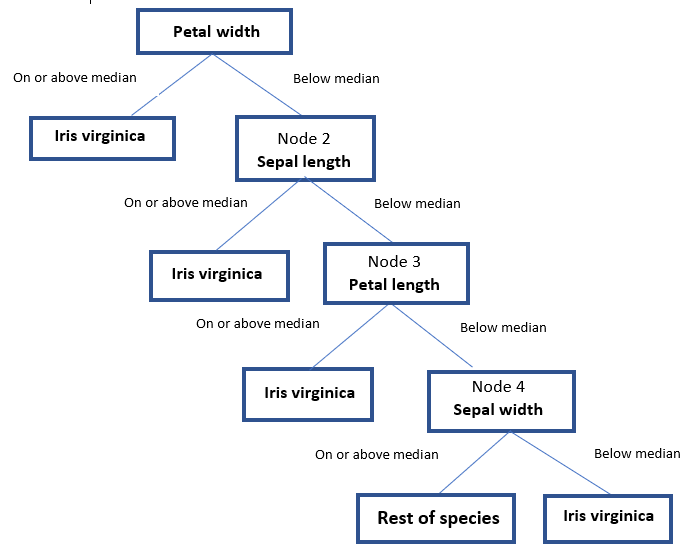

### 9.2 `Iris setosa`

We put together all the **weights of every column** that belong to this species:(Gini Index of the columns)

|Total Gini Index I.set|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH|
|----------------------|------------|-----------|------------|-----------|
|Results|0.3517|0.2825|0.083|0.1345|

The order of the nodes is:

1. Petal length
2. Petal width
3. Sepal width
4. Sepal length

The conditioned probabilities are:

|Conditioned Probab|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH| 
|------------------|------------|-----------|------------|-----------| 
|above Iris s.|0.0|0.7714|0.0|0.0|
|above not Iris s.|1.0|0.2286|1.0|1.0|

|Conditioned Probab|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH| 
|------------------|------------|-----------|------------|-----------| 
|below Iris set.|0.4138|0.1059|0.4286|0.4444|
|below not Iris set.|0.5862|0.8941|0.5714|0.5555|

First node: **petal length** has 0% occurrences of `Iris setosa` above the indicator, so they must be **below**.
<br>
Second node: **petal width** has 0% occurrences of `Iris setosa` above the indicator, so they must be **below**.
<br>
Third node: **sepal width** has 77% occurrences of `Iris setosa` above and 89% below and not of the species, so they must be **above**.
<br>
Fourth node: **sepal length** has 0% probability of being above the indicator,  so they must be **below**.

This decision tree follows the same splits as with the median indicator:

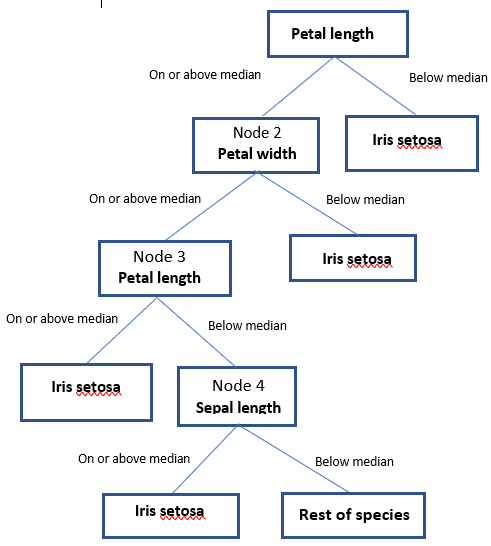

### 9.3 `Iris versicolor`

We put together all the **weights of every column** that belong to this species:(Gini Index of the columns)

|Total Gini Index I.vers|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH|
|-----------------------|------------|-----------|------------|-----------|
|Results|0.4462|0.3699|0.3428|0.3537|

The order of the nodes is:

1. Petal length
2. Petal width
3. Sepal width
4. Sepal length

The conditioned probabilities are:

|Conditioned Probab|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH| 
|------------------|------------|-----------|------------|-----------| 
|above Iris ver.|0.2424|0.0286|0.02777|0.0256|
|above not Iris ver.|0.7575|0.9714|0.9722|0.9743|

|Conditioned Probab|SEPAL LENGTH|SEPAL WIDTH|PETAL LENGTH|PETAL WIDTH| 
|------------------|------------|-----------|------------|-----------| 
|below Iris ver.|0.3908|0.4823|0.4881|0.5062|
|below not Iris ver.|0.6092|0.5176|0.5119|0.4938|

First node: **petal length** has 97% occurrences of no `Iris versicolor` being above the indicator, so they must be **below**.
<br>
Second node: **petal width** has 97% probability of being **not** of the species and above the indicator, so they must be **below**.
<br>
Third node: **sepal width** has 97% occurrences of being above and not of the species, so they must be **below**.
<br>
Fourth node: **sepal length** has 74% occurrences of being above and not of the species, so it must **below**. 
<br>
The below probabilities are very similar within each sepal/petal characteristic and it would not be significative. That is why only the above occurrences have been used.

The decision tree goes as follows:

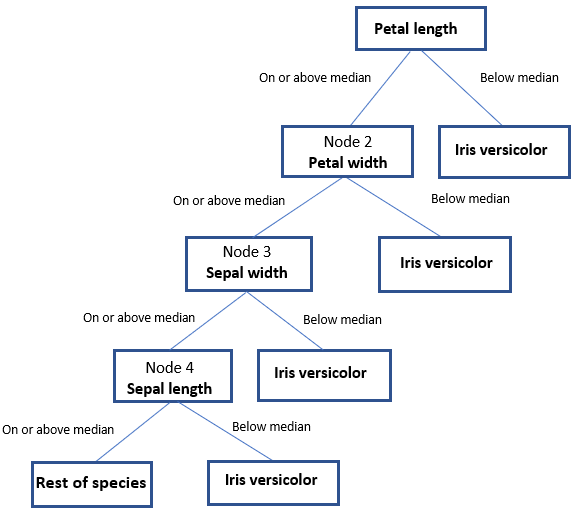

### 10 - EFFICIENCY OF THE DECISION TREES

#### 10.1 Test efficiency of the decision tree for `Iris virginica`.

In [67]:
def predict_species(df):
    if df['petal-width'] >= pw_indicator:
        if df['petal-length'] >= sl_indicator:
            #if df['sepal-length'] >= pl_indicator:
                #if df['sepal-width'] <= sw_indicator:
                 #   return "Iris-virginica"
                #else:
                #    return None
            #    return "Iris-virginica"
            #else:
            #    return None
            return "Iris-virginica"
        else:
            return None

# use the predict_species(df) function to predict the species, count how many are predicted correct and use this to calculate
# the proportion correct
correct = 0
test_size = test.shape[0]
for i in range(0, test_size):
    species = predict_species(test.iloc[i])
    if species == test.iloc[i]['species']:
        correct += 1

print ("Proportion correctly identified", correct / test_size) 

Proportion correctly identified 0.0


The efficiency of classification of `Iris virginica` is 0 with 2, 3, or 4 nodes.
<br>
This is not useful for classification purposes.

#### 10.2 Test efficiency of the decision tree for `Iris setosa`.

In [71]:
def predict_species(df):
    if df['petal-length'] <= pl_indicator:
        if df['petal-width'] <= pw_indicator:
            #if df['sepal-width'] >= sl_indicator:
                #if df['sepal-length'] <= sw_indicator:
                #    return "Iris-setosa"
                #else:
                #    return None
            #    return "Iris-setosa"
            #else:
            #    return None
            return "Iris-setosa"
        else:
            return None

# use the predict_species(df) function to predict the species, count how many are predicted correct and use this to calculate
# the proportion correct
correct = 0
test_size = test.shape[0]
for i in range(0, test_size):
    species = predict_species(test.iloc[i])
    if species == test.iloc[i]['species']:
        correct += 1

print ("Proportion correctly identified", correct / test_size)

Proportion correctly identified 0.4666666666666667


The efficiency of classification of `Iris setosa` is 0 for 3 and 4 nodes and 47% for 2 nodes. Using the petals measures to classify the 3 species is too restricted to be used in general as a classification tool.

#### 10.3 Test efficiency of the decision tree for `Iris versicolor`.

In [74]:
def predict_species(df):
    if df['petal-length'] <= pl_indicator:
        if df['petal-width'] <= sw_indicator:
            #if df['sepal-width'] <= sl_indicator:
                #if df['sepal-length'] <= pw_indicator:
                #    return "Iris-versicolor"
                #else:
                #    return None
            #    return "Iris-versicolor"
            #return None
            return "Iris-versicolor"
        else:
            return None

# use the predict_species(df) function to predict the species, count how many are predicted correct and use this to calculate
# the proportion correct
correct = 0
test_size = test.shape[0]
for i in range(0, test_size):
    species = predict_species(test.iloc[i])
    if species == test.iloc[i]['species']:
        correct += 1

print ("Proportion correctly identified", correct / test_size) 

Proportion correctly identified 0.26666666666666666


The efficiency of classification of `Iris versicolor` is 26.6% for 2 and 3 nodes and 0 for all nodes. As with `Iris setosa`, basing the classification on mostly one character is not very reliable.

### 11 - PLOT GRAPH

For the petals we have:

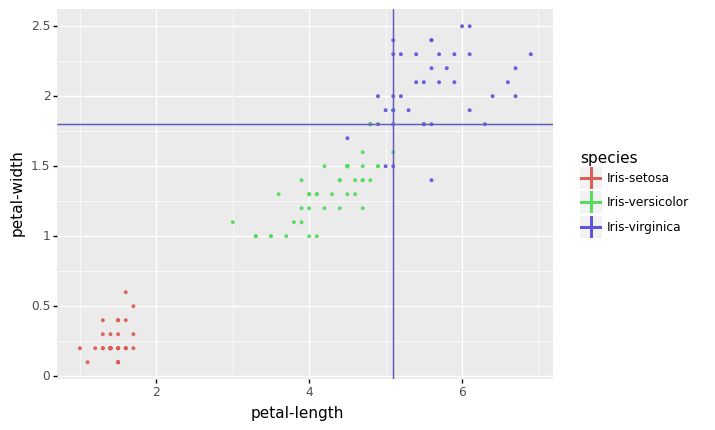

<ggplot: (170771348032)>

In [75]:
import plotly
import ggplot
from pandas import Timestamp
from plotnine import *
import warnings
warnings.filterwarnings('ignore', module='plotnine') 

(ggplot(train, aes(x='petal-length', y='petal-width', color='species')) + 
        geom_point(alpha =0.9, size = 0.6) +
        geom_vline(train, aes(xintercept=pl_indicator, color='species')) +
        geom_hline(train, aes(yintercept=pw_indicator, color='species'))
)

For the sepals we have:

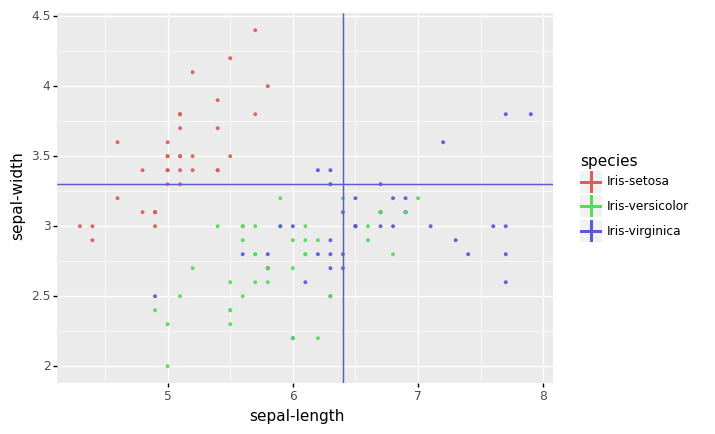

<ggplot: (170771712759)>

In [76]:
import plotly
import ggplot
from pandas import Timestamp
from plotnine import *
import warnings
warnings.filterwarnings('ignore', module='plotnine') 

(ggplot(train, aes(x='sepal-length', y='sepal-width', color='species')) + 
        geom_point(alpha =0.9, size = 0.6) +
        geom_vline(train, aes(xintercept=sl_indicator, color='species')) +
        geom_hline(train, aes(yintercept=sw_indicator, color='species'))
)

### CONCLUSION

Decision trees based in the upper quintiles, are in general not reliable for classification purposes, as they do not work well with 3 nodes (using 4 nodes is stretching the decision trees too much, not just for this indicator, but for all indicators) and even with 2 nodes does not classify the species well.
<br>
<br>
In general, I would not use the upper quintiles for classification, whatever the split used in the calculations.